In [1]:
import os
import sys
import torch
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from typing import NamedTuple, Sequence, Union
import cv2
import matplotlib.image as mpimg
import torchvision.transforms as transform

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
mesh = load_objs_as_meshes(['nimrud.obj'], device=device)

/home/vdamarla/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


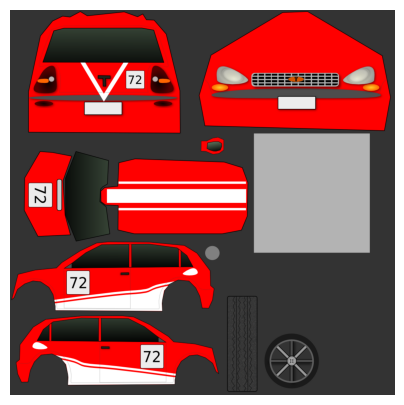

In [3]:
plt.figure(figsize=(5,5))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

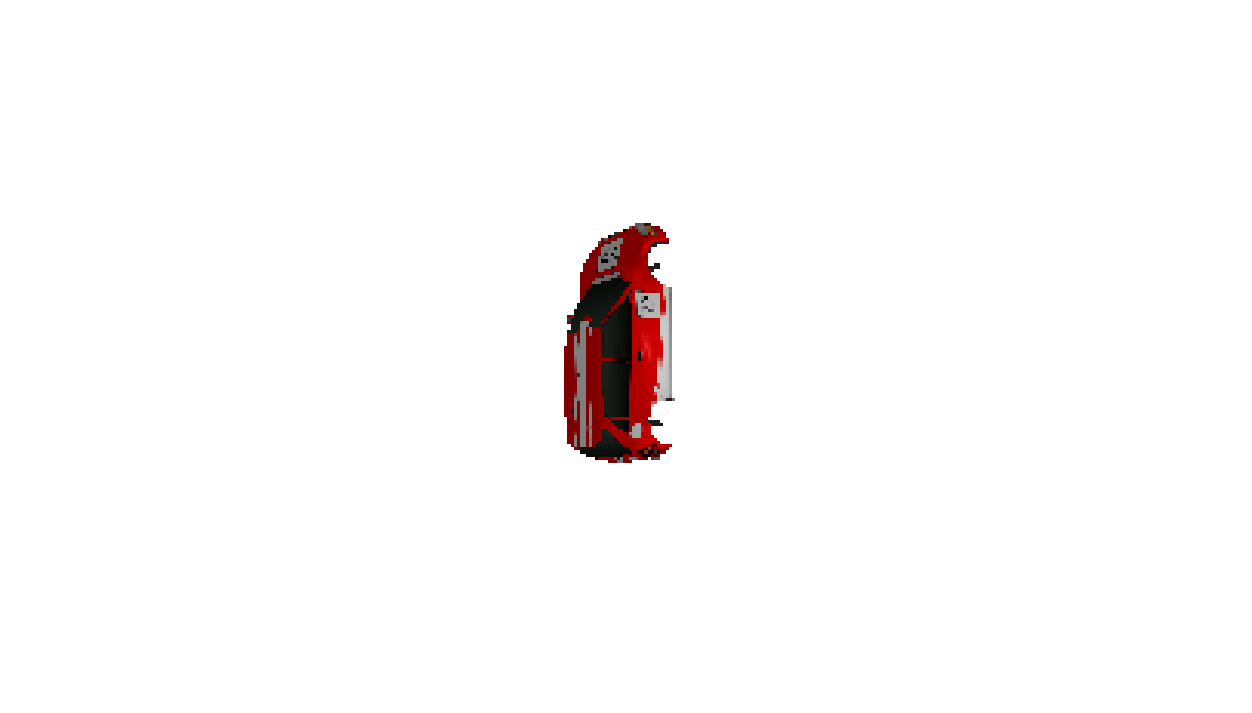

In [15]:
R, T = look_at_view_transform(-20, 170, 50)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
raster_settings = RasterizationSettings(image_size=(225, 400), blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[5.0 , 0.0, 0.0]])
rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)

verts_shape = mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
mesh = mesh.offset_verts(deform_verts)

fragments = rasterizer.forward(mesh)
images = shader(fragments, mesh)
# print(images)

# images = renderer(mesh)
plt.figure(figsize=(400/25, 225/25))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.axis("off")
plt.savefig('car.png', dpi=25)

In [16]:
N, H, W, K = fragments.pix_to_face.shape
device = fragments.pix_to_face.device

# Mask for the background.
is_background = fragments.pix_to_face[..., 0] < 0  # (N, H, W)
print(is_background.shape)

torch.Size([1, 225, 400])


In [17]:
background = torch.tensor(cv2.imread('/home/vdamarla/adversarial-vehicle-testing/src/adversarial_vehicle_testing/car/straight_scene.jpg'), device=device).float() / 255.0
combined = background.unsqueeze(0) * is_background.unsqueeze(-1) + torch.flip(images[...,:3], [-1]) * torch.logical_not(is_background.unsqueeze(-1))
plt.figure(figsize=(400, 225))
plt.imshow(torch.flip(combined[0, ..., :3], [-1]).detach().cpu().numpy())
plt.axis("off")
cv2.imwrite('combined.png', combined[0].detach().cpu().numpy() * 255)

True

In [18]:
model = torch.load('/home/vdamarla/adversarial-vehicle-testing/src/adversarial_vehicle_testing/car/DAVE2v3.pt', map_location=torch.device('cuda')).eval()
orig_image = torch.tensor(cv2.imread('/home/vdamarla/adversarial-vehicle-testing/src/adversarial_vehicle_testing/car/straight_scene.jpg'), device=device)
pert_image = torch.tensor(cv2.imread('/home/vdamarla/adversarial-vehicle-testing/src/adversarial_vehicle_testing/car/combined.png'), device=device)
orig_image = orig_image.detach().cpu()
pert_image = pert_image.detach().cpu()
processed_orig = model.process_image(orig_image).to(torch.device('cuda'))
processed_pert = model.process_image(pert_image).to(torch.device('cuda'))
print(processed_orig.shape)
print(processed_pert.shape)

transformation = transform.Resize((135, 240))

resized_orig = transformation(processed_orig)
resized_pert = transformation(processed_pert)
orig_angles = model(resized_orig)
pert_angles = model(resized_pert)
print("Original steering angle:", orig_angles)
print("Adversarial outputs:", pert_angles)



torch.Size([1, 3, 225, 400])
torch.Size([1, 3, 225, 400])
Original steering angle: tensor([[-0.0231]], device='cuda:0', grad_fn=<AddmmBackward0>)
Adversarial outputs: tensor([[-0.0099]], device='cuda:0', grad_fn=<AddmmBackward0>)


### Perturbation: Modifying car translation 

tensor(0.)
tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)
tensor(5.)
tensor(6.)
tensor(7.)
tensor(8.)
tensor(9.)
tensor(10.)
tensor(11.)
tensor(12.)
tensor(13.)


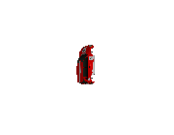

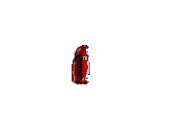

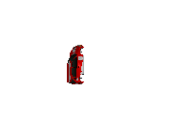

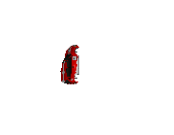

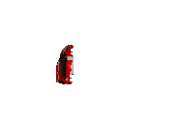

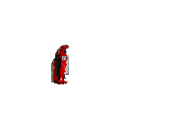

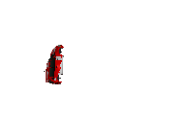

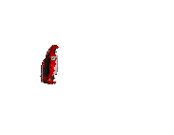

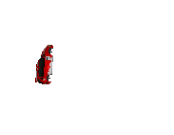

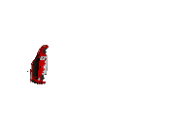

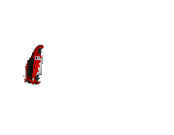

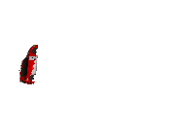

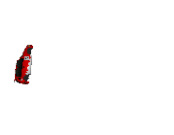

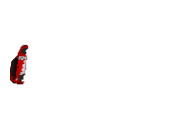

In [ ]:
# Create new T tuple
def render_car_translation_pert(x_change, y_change, z_change):
    mesh = load_objs_as_meshes(['nimrud.obj'], device=device)
    R, T = look_at_view_transform(-20, 170, 50)
    T[0][0] += x_change
    T[0][1] += y_change
    T[0][2] += z_change
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    raster_settings = RasterizationSettings(image_size=(120, 160), blur_radius=0.0, faces_per_pixel=1)
    lights = PointLights(device=device, location=[[5.0 , 0.0, 0.0]])
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)

    verts_shape = mesh.verts_packed().shape
    deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
    mesh = mesh.offset_verts(deform_verts)

    fragments = rasterizer.forward(mesh)
    images = shader(fragments, mesh)

    plt.figure(figsize=(160/80, 120/80))
    print(T[0][0])
    plt.imshow(images[0, ..., :3].detach().cpu().numpy())
    plt.axis("off")

# Understanding how the translation works
for i in range(14):
    render_car_translation_pert(i, 0, 0)
    N, H, W, K = fragments.pix_to_face.shape
    device = fragments.pix_to_face.device
    is_background = fragments.pix_to_face[..., 0] < 0  # (N, H, W)
    background = torch.tensor(cv2.imread('/home/vdamarla/adversarial-vehicle-testing/src/adversarial_vehicle_testing/car/10.png'), device=device).float() / 255.0
    combined = background.unsqueeze(0) * is_background.unsqueeze(-1) + torch.flip(images[...,:3], [-1]) * torch.logical_not(is_background.unsqueeze(-1))
    plt.figure(figsize=(160, 120))
    plt.imshow(torch.flip(combined[0, ..., :3], [-1]).detach().cpu().numpy())
    plt.axis("off")
    plt.savefig('combined' + str(i) + '.png', dpi=80)
    

